<a href="https://colab.research.google.com/github/Noam2710/StyleGAN_Interpolation/blob/master/Copy_of_style_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!git clone https://github.com/NVlabs/stylegan.git

Cloning into 'stylegan'...
remote: Enumerating objects: 83, done.
remote: Total 83 (delta 0), reused 0 (delta 0), pack-reused 83
Unpacking objects: 100% (83/83), done.


In [3]:
import sys
sys.path.insert(0, "/content/stylegan")

import dnnlib
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib.tflib as tflib
import config
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import cv2
from matplotlib import pyplot as plt
import pickle
import glob
list_of_models = ['vgg16','resnet50','senet50']
model_to_color = {'vgg16':'b','resnet50':'r','senet50':'g'}
list_of_algo = ['OpenAI']
algo_to_color = {'OpenAI':'b','CMA-ES':'r','RandomSearch':'g'}
fps_in_video = 5
image_size_in_video = (600,600)
es_learning_rate = 0.1
es_sigma = 0.5
save_images = True
rnd = np.random.RandomState(seed=5)
base_dir_to_save_charts = '/content/drive/My Drive/logs_sigma_diffe'

In [4]:
tflib.init_tf()
with open('/content/drive/My Drive/karras2019stylegan-ffhq-1024x1024.pkl', "rb") as f:
  _G, _D, Gs = pickle.load(f)











Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Source image


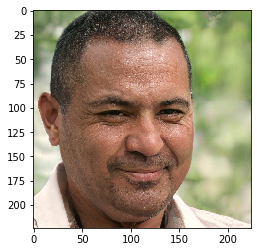

Destination image


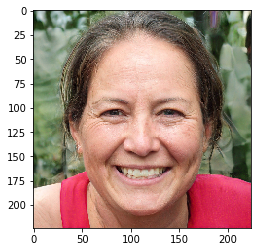

In [5]:
latents = rnd.randn(2, Gs.input_shape[1])
dest_latent = latents[1,np.newaxis]
source_latent = latents[0,np.newaxis]
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
source_image = np.squeeze(Gs.run(source_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
dest_image = np.squeeze(Gs.run(dest_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
print("Source image")
source_res = cv2.resize(np.squeeze(source_image), dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
plt.imshow(source_res)
plt.show()
print("Destination image")
dest_res = cv2.resize(np.squeeze(dest_image), dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
plt.imshow(dest_res)
plt.show()

In [6]:
!pip install evostra
from evostra import EvolutionStrategy

  Created wheel for evostra: filename=evostra-2.5.2-py2.py3-none-any.whl size=5628 sha256=e9d0be079739842022db4476b3807b729c432e1f6bf8c01e91f0bc72627dd299
  Stored in directory: /root/.cache/pip/wheels/8a/d2/0a/19e1279290da14ce7c3d25589e21f264037ac9fb38ae18aa55
Successfully built evostra


In [7]:
pip install keras_vggface

In [8]:
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from keras.preprocessing import image
from datetime import datetime

def predict_features_from_image(res):
  res = image.img_to_array(res)
  res = np.expand_dims(res, axis=0)
  res = utils.preprocess_input(res, version=2) # or version=2
  return vgg_features.predict(res)

Using TensorFlow backend.


In [0]:
def get_reward_by_vgg(latent_vector):
  image_to_check = np.squeeze(Gs.run(latent_vector[0], None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
  image_after_resize = cv2.resize(image_to_check, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  image_to_check_features = predict_features_from_image(image_after_resize)
  return -np.linalg.norm(image_to_check_features - features_of_dest_images)

def get_rewared_by_vgg_cosine(latent_vector):
  image_to_check = np.squeeze(Gs.run(latent_vector[0], None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
  image_after_resize = cv2.resize(image_to_check, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  image_to_check_features = predict_features_from_image(image_after_resize)
  return cosine_similarity(np.squeeze(image_to_check_features),np.squeeze(features_of_dest_images))*50

def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

def get_mse_between_pictures(latent_vector):
  image_to_check = np.squeeze(Gs.run(latent_vector[0], None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt))
  image_after_resize = cv2.resize(image_to_check, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  return -np.linalg.norm(dest_res - image_after_resize)

def get_distnace_between_vectors(latent_vector):
  return -np.linalg.norm(source_latent - latent_vector[0])

In [0]:
def run_es_model(verbose=False,run_each_time=2,total_runs=600,save_images=False):
  global features_of_dest_images
  features_of_dest_images = predict_features_from_image(dest_res)
  init_latent_vector = [source_latent]
  source_image = Gs.run(source_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt)
  res = cv2.resize(np.squeeze(source_image), dsize=image_size_in_video, interpolation=cv2.INTER_CUBIC)
  list_of_images = [cv2.cvtColor(res, cv2.COLOR_BGR2RGB)]
  list_of_rewards = []
  es = EvolutionStrategy(init_latent_vector, get_reward_by_vgg, population_size=50, sigma=es_sigma, learning_rate=es_learning_rate, num_threads=1)
  for i in range (int(total_runs/run_each_time)):
    print("Iterations {} - {} | Reward {}".format(i*run_each_time,(i+1)*run_each_time,es.get_reward(es.get_weights())))
    es.run(run_each_time,print_step=run_each_time*10000)
    list_of_rewards.append(es.get_reward(es.get_weights()))
    if verbose or save_images:
      images = Gs.run(es.get_weights()[0], None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt)
      res = cv2.resize(np.squeeze(images), dsize=image_size_in_video, interpolation=cv2.INTER_CUBIC)
    if verbose:
      plt.imshow(res)
      plt.show()
    if save_images:
      list_of_images.append(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
  return list_of_images,list_of_rewards

In [0]:
def export_list_to_pickle(network_name,name,differ=False):
  for algo in list_of_algo:
    if differ:
      with open('{}/{}--{}.pkl'.format(base_dir_to_save_charts,algo,name), 'wb') as f:
        pickle.dump(model_to_rewards[network_name][algo], f)
    else:
      with open('{}/{}--{}.pkl'.format(base_dir_to_save_charts,network_name,name), 'wb') as f:
        pickle.dump(model_to_rewards[network_name][algo], f)

def print_graphs_for_feature_extraction_network(network_name):
  for algo in list_of_algo:
    plt.plot(list(range(1,len(model_to_rewards[network_name][algo])+1)),model_to_rewards[network_name][algo], algo_to_color[algo], label=algo)
  plt.title(network_name)
  plt.legend()
  plt.show()

In [0]:
def list_of_images_to_video(image_list,model_name,algo,date_time):  
  out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'mp4v'), fps_in_video, image_size_in_video)
  for i in range(len(images_list)):
      out.write(images_list[i])
  out.release()

  !mv 'project.avi' '/content/drive/My Drive/videos_of_transformation'
  os.rename('/content/drive/My Drive/videos_of_transformation/project.avi', '/content/drive/My Drive/videos_of_transformation/{}-{}--{}.avi'.format(model_name,algo,date_time))

In [13]:
global es_learning_rate
global es_sigma
global save_images
for sig in [0.01]:
  print("checking sigma " + str(sig))
  es_sigma = sig
  model_to_rewards = {}
  features_of_dest_images = None
  for model in list_of_models:
    model_to_rewards[model] = {}
    for algo in list_of_algo:
      now = datetime.now() # current date and time
      date_time = now.strftime("%m-%d-%Y-%H-%M-%S")
      vgg_features = VGGFace(model=model, include_top=False, input_shape=(224, 224, 3), pooling='avg')
      if algo == 'OpenAI':
        images_list,reward_list = run_es_model(verbose=False,run_each_time=2,total_runs=600,save_images=save_images)
      if algo == 'random':
        images_list,reward_list = run_random_model(verbose=False,run_each_time=2,total_runs=600,save_images=save_images)

      if save_images:
        list_of_images_to_video(images_list,model,algo,date_time)
      model_to_rewards[model][algo] = reward_list
    export_list_to_pickle(model,es_sigma)
    save_images = False

checking sigma 0.01


58916864/58909280 [==============================] - 3s 0us/step


Iterations 0 - 2 | Reward -108.5032958984375
Iterations 2 - 4 | Reward -93.1151351928711
Iterations 4 - 6 | Reward -89.31429290771484
Iterations 6 - 8 | Reward -105.888916015625
Iterations 8 - 10 | Reward -91.45702362060547
Iterations 10 - 12 | Reward -91.59227752685547
Iterations 12 - 14 | Reward -99.49710083007812
Iterations 14 - 16 | Reward -103.6811752319336
Iterations 16 - 18 | Reward -93.78955841064453
Iterations 18 - 20 | Reward -85.98799896240234
Iterations 20 - 22 | Reward -85.40931701660156
Iterations 22 - 24 | Reward -94.18946075439453
Iterations 24 - 26 | Reward -87.93277740478516
Iterations 26 - 28 | Reward -86.22787475585938
Iterations 28 - 30 | Reward -94.48196411132812
Iterations 30 - 32 | Reward -91.84725189208984
Iterations 32 - 34 | Reward -87.55253601074219
Iterations 34 - 36 | Reward -85.98591613769531
Iterations 36 - 38 | Reward -82.32797241210938
Iterations 38 - 40 | Reward -

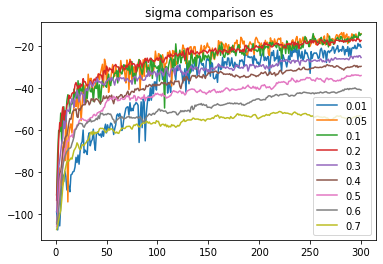

In [14]:
for log_file in glob.glob("/content/drive/My Drive/logs_sigma/*.*"):
  with open(log_file, 'rb') as f:
    label = log_file.split('/')[5].split('--')[1].split('.pkl')[0]
    my_list = pickle.load(f)
    plt.plot(list(range(1,len(my_list)+1)),my_list, label=label)
    
plt.title("sigma comparison es")
plt.legend()
# plt.show()
plt.savefig("Sigma_Comparison_es.png")
!mv 'Sigma_Comparison_es.png' '/content/drive/My Drive'

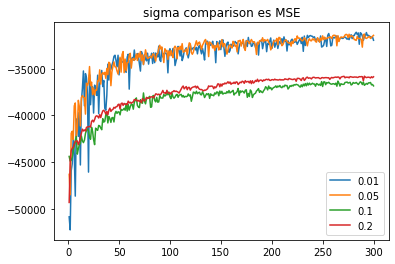

In [15]:
for log_file in glob.glob("/content/drive/My Drive/logs_sigma_MSE/*.*"):
  with open(log_file, 'rb') as f:
    label = log_file.split('/')[5].split('--')[1].split('.pkl')[0]
    my_list = pickle.load(f)
    plt.plot(list(range(1,len(my_list)+1)),my_list, label=label)
    
plt.title("sigma comparison es MSE")
plt.legend()
# plt.show()
plt.savefig("Sigma_Comparison_es_MSE.png")
!mv 'Sigma_Comparison_es_MSE.png' '/content/drive/My Drive'

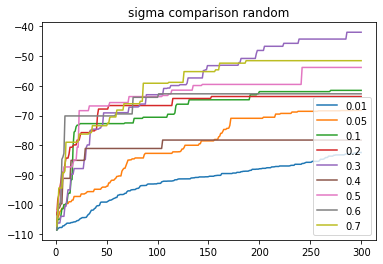

In [16]:
for log_file in glob.glob("/content/drive/My Drive/logs_sigma_random/*.*"):
  with open(log_file, 'rb') as f:
    label = log_file.split('/')[5].split('--')[1].split('.pkl')[0]
    my_list = pickle.load(f)
    plt.plot(list(range(1,len(my_list)+1)),my_list, label=label)
    
plt.title("sigma comparison random")
plt.legend()
# plt.show()
plt.savefig("sigma_comparison_random.png")
!mv 'sigma_comparison_random.png' '/content/drive/My Drive'

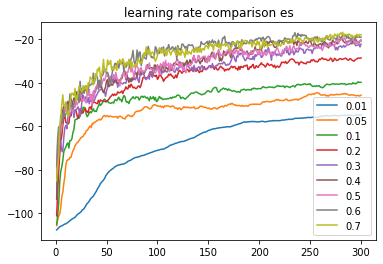

In [17]:
for log_file in glob.glob("/content/drive/My Drive/logs_learning_rate/*.*"):
  with open(log_file, 'rb') as f:
    label = log_file.split('/')[5].split('--')[1].split('.pkl')[0]
    my_list = pickle.load(f)
    plt.plot(list(range(1,len(my_list)+1)),my_list, label=label)
    
plt.title("learning rate comparison es")
plt.legend()
# plt.show()
plt.savefig("learning_rate_comparison_es.png")
!mv 'learning_rate_comparison_es.png' '/content/drive/My Drive'

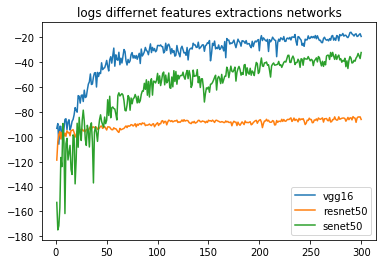

In [10]:
for log_file in glob.glob("/content/drive/My Drive/logs_sigma_diffe/*.*"):
  with open(log_file, 'rb') as f:
    label = log_file.split('/')[5].split('--')[0].split('.pkl')[0]
    my_list = pickle.load(f)
    plt.plot(list(range(1,len(my_list)+1)),my_list, label=label)
    
plt.title("logs differnet features extractions networks")
plt.legend()
# plt.show()
plt.savefig("logs_sigma_diffe.png")
!mv 'logs_sigma_diffe.png' '/content/drive/My Drive'

In [6]:
my_list

[-152.72926,
 -174.83994,
 -171.50615,
 -157.1309,
 -116.5861,
 -123.95655,
 -89.26146,
 -102.49,
 -161.6872,
 -105.56283,
 -101.1749,
 -118.58334,
 -112.854645,
 -106.84194,
 -126.196556,
 -130.22282,
 -98.38504,
 -99.89379,
 -137.8008,
 -119.15498,
 -89.05324,
 -108.3409,
 -84.30207,
 -96.25685,
 -102.88861,
 -86.52825,
 -78.49081,
 -87.32529,
 -101.92863,
 -106.87897,
 -90.69858,
 -95.11562,
 -108.145836,
 -91.73287,
 -88.7212,
 -104.354904,
 -137.04453,
 -96.16752,
 -91.85021,
 -96.74913,
 -103.62788,
 -93.26585,
 -86.125786,
 -82.26493,
 -87.57107,
 -90.11032,
 -92.06664,
 -84.07233,
 -89.36128,
 -86.62638,
 -70.12543,
 -82.80059,
 -67.32454,
 -84.65208,
 -76.61463,
 -75.94962,
 -77.24119,
 -77.58584,
 -81.59259,
 -86.382256,
 -66.83075,
 -64.55228,
 -67.122025,
 -66.20898,
 -65.218636,
 -66.363686,
 -70.81143,
 -78.678185,
 -79.09712,
 -74.511635,
 -66.80121,
 -68.15886,
 -78.569,
 -68.75683,
 -73.381935,
 -69.334435,
 -68.562836,
 -65.90892,
 -68.26438,
 -72.7058,
 -67.287735,
 

In [0]:
def run_random_model(verbose=False,run_each_time=2,total_runs=600,save_images=False):
  global features_of_dest_images
  features_of_dest_images = predict_features_from_image(dest_res)
  init_latent_vector = [source_latent]
  source_image = Gs.run(source_latent, None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt)
  res = cv2.resize(np.squeeze(source_image), dsize=image_size_in_video, interpolation=cv2.INTER_CUBIC)
  list_of_images = [cv2.cvtColor(res, cv2.COLOR_BGR2RGB)]
  list_of_rewards = []

  current_individual = source_latent
  currect_fitness = get_reward_by_vgg([source_latent])
  for i in range (total_runs):
    print("Iteration {} -- reward {}".format(str(i),str(currect_fitness)))  
    jittered = es_sigma * np.random.randn(*source_latent.shape)
    ind_to_try = current_individual + jittered
    ind_to_try_fitness = get_reward_by_vgg([ind_to_try])

    if ind_to_try_fitness>currect_fitness:
      current_individual = ind_to_try
      currect_fitness = ind_to_try_fitness

    if i%run_each_time == 0:
      list_of_rewards.append(currect_fitness)

    if verbose or save_images:
      images = Gs.run(es.get_weights()[0], None, truncation_psi=0.7, randomize_noise=False, output_transform=fmt)
      res = cv2.resize(np.squeeze(images), dsize=image_size_in_video, interpolation=cv2.INTER_CUBIC)
    if verbose:
      plt.imshow(res)
      plt.show()
    if save_images:
      list_of_images.append(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

  return list_of_images,list_of_rewards

In [19]:
!ls

drive  sample_data  stylegan


In [0]:
!rm -f Sigma_Comparison_es.